#                            Machine learning pour la modélidation du risque de crédit avec python(credit scorting)
Auteur: MINLEKIB Yendouboan

Dans ce projet nous esssayerons de construire un algorithme capable de prédire si une personne est en de défaut de payement(1:defaut, 0: non défaut)

In [58]:
#Importation des librairies
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Prepare Data

### Import

###  Les données proviennent de kaggle(https://www.kaggle.com/datasets/laotse/credit-risk-dataset)

In [2]:
def wrangle(filepath):
    # importation des données
    df = pd.read_csv(filepath)
    # elimination des valeurs aberantes au niveau de la variable person_age
    mask_age = df["person_age"]<100
    df = df[mask_age]
    # elimination des valeurs aberantes au niveau de la variable person_age person_income
    low, high = df["person_income"].quantile([0.0, 0.9])
    mask_person_income = df["person_income"].between(low, high)
    df = df[mask_person_income]
    return df

In [4]:
df = wrangle("credit_scorting_data/credit_risk_dataset.csv")
print(df.shape)
df.head(10)

(29322, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3


### Explore

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29322 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29322 non-null  int64  
 1   person_income               29322 non-null  int64  
 2   person_home_ownership       29322 non-null  object 
 3   person_emp_length           28454 non-null  float64
 4   loan_intent                 29322 non-null  object 
 5   loan_grade                  29322 non-null  object 
 6   loan_amnt                   29322 non-null  int64  
 7   loan_int_rate               26526 non-null  float64
 8   loan_status                 29322 non-null  int64  
 9   loan_percent_income         29322 non-null  float64
 10  cb_person_default_on_file   29322 non-null  object 
 11  cb_person_cred_hist_length  29322 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.9+ MB


In [5]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [6]:
df["person_income"].describe().apply("{0:,.0f}".format)

count       32,581
mean        66,075
std         61,983
min          4,000
25%         38,500
50%         55,000
75%         79,200
max      6,000,000
Name: person_income, dtype: object

In [7]:
# Etudions la variable cible (loan_status)
# frequence des class de la variable cible
df["loan_status"].value_counts(normalize=True)

0    0.781836
1    0.218164
Name: loan_status, dtype: float64

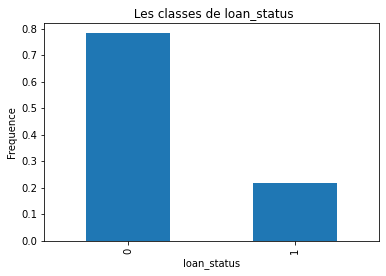

In [8]:
# diagramme en barre de la variable cible(loan_status)
df["loan_status"].value_counts(normalize=True).plot(
    kind = "bar",
    xlabel = "loan_status",
    ylabel = "Frequence",
    title = " Les classes de loan_status"
);

Nous pouvons remaquer qu'il y'a un deséquilibre des classes

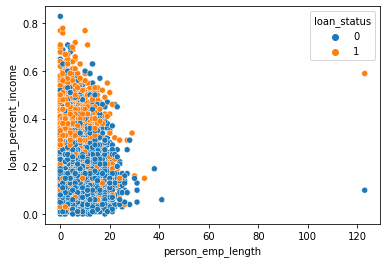

In [9]:
#Nuage de point entre la variable cible et la durée d'activité profetionnelle
sns.scatterplot(
    x=df["person_emp_length"],
    y=df["loan_percent_income"],
    hue=df["loan_status"]
    
);

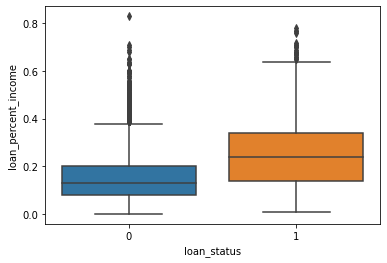

In [10]:
# loan_percent_income Vs loan_status
sns.boxplot(x="loan_status", y="loan_percent_income", data=df);

In [11]:
def box_plot(b):
    sns.boxplot(x="loan_status", y=b, data=df)
    return plt.show()

In [12]:
variable_numeric = ["person_age","loan_amnt", "loan_int_rate", "person_income"]

In [13]:
interact(box_plot, b=variable_numeric)

interactive(children=(Dropdown(description='b', options=('person_age', 'loan_amnt', 'loan_int_rate', 'person_i…

<function __main__.box_plot(b)>

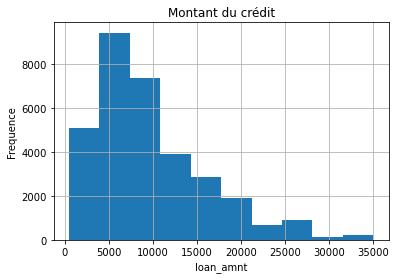

In [14]:
df["loan_amnt"].hist()
plt.xlabel("loan_amnt")
plt.ylabel("Frequence")
plt.title("Montant du crédit");

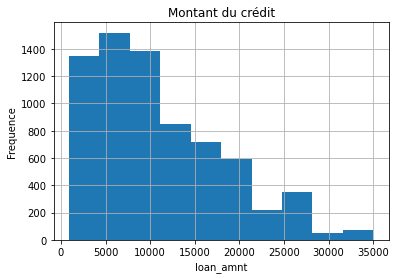

In [15]:
# histogramme des gens en defauts de loan_amnt
mask = df["loan_status"]==1
df[mask]["loan_amnt"].hist()
plt.xlabel("loan_amnt")
plt.ylabel("Frequence")
plt.title("Montant du crédit");

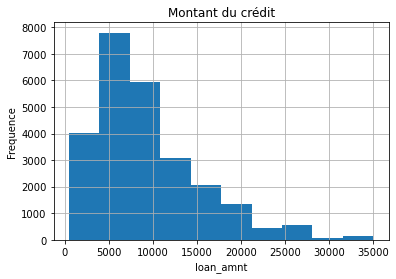

In [16]:
# histogramme des gens qui ne sont pas en defauts de loan_amnt
mask = df["loan_status"]==0
df[mask]["loan_amnt"].hist()
plt.xlabel("loan_amnt")
plt.ylabel("Frequence")
plt.title("Montant du crédit");

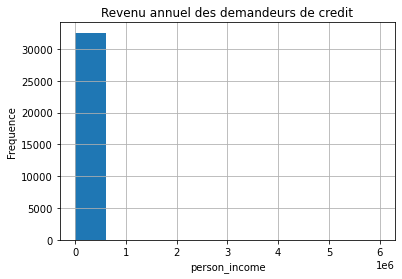

In [17]:
df["person_income"].hist()
plt.xlabel("person_income")
plt.ylabel("Frequence")
plt.title("Revenu annuel des demandeurs de credit");

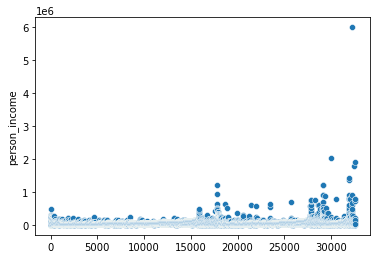

In [18]:
# nuage de point des revenus annuels
sns.scatterplot(
    x= df.index,
    y=df["person_income"]
);

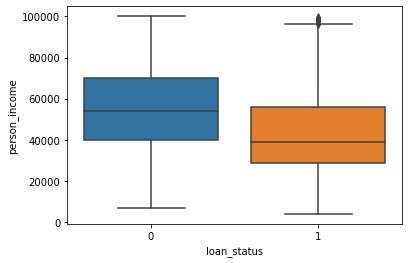

In [19]:
sns.boxplot(x="loan_status", y="person_income", data=df[df["person_income"]<100000]);

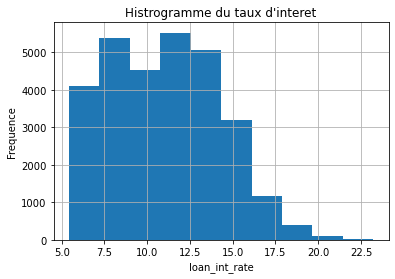

In [20]:
# histogramme du taux d'interet
df["loan_int_rate"].hist()
plt.xlabel("loan_int_rate")
plt.ylabel("Frequence")
plt.title("Histrogramme du taux d'interet");

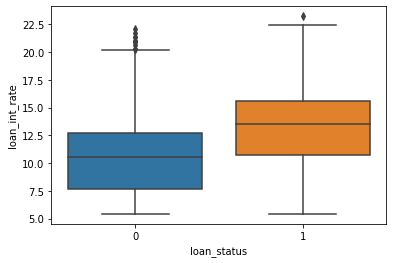

In [21]:
# relation entre la variable cible et le taux d'interet
sns.boxplot(x="loan_status", y="loan_int_rate", data=df);

Nous pouvons remarquer que les clients en defauts de payement ont en moyenne un t'interet de credit plus elevé

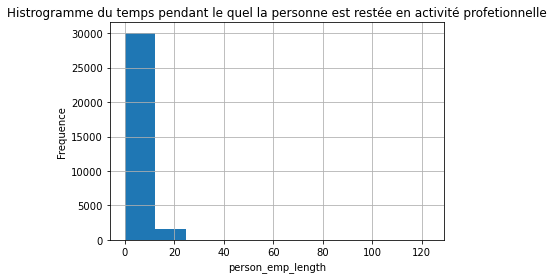

In [22]:
# histrogramme de la variable person_emp_length(temps pendant le quel la personne est restée en activité profetionnelle)
df["person_emp_length"].hist()
plt.xlabel("person_emp_length")
plt.ylabel("Frequence")
plt.title("Histrogramme du temps pendant le quel la personne est restée en activité profetionnelle");

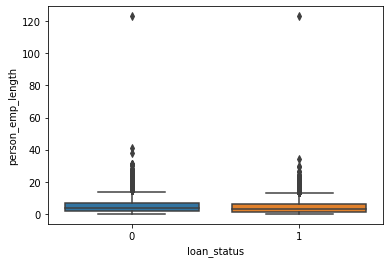

In [23]:
# relation entre la variable cible et le temps pendant le quel la personne est restée en activité profetionnelle
sns.boxplot(x="loan_status", y="person_emp_length", data=df);

Malgré la presence des valeures aberantes nous pouvons remarquer que les personnes en defauts de payement ont une durée d'activité professionnelle moins que les autres. 

Filtrons les données pour en voir claire 

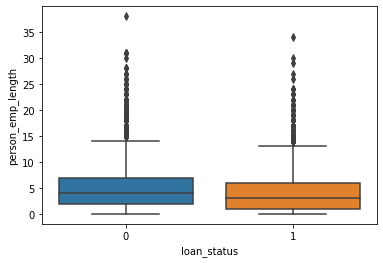

In [24]:
sns.boxplot(x="loan_status", y="person_emp_length", data=df[df["person_emp_length"]<40]);

Analysons la variable indiquant l'age.
D'abord par l'histogramme et apres par la boite a moustache

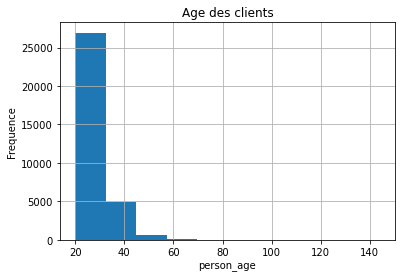

In [25]:
df["person_age"].hist()
plt.xlabel("person_age")
plt.ylabel("Frequence")
plt.title("Age des clients");

La majorité des clients ont un age compris entre 20 e 45

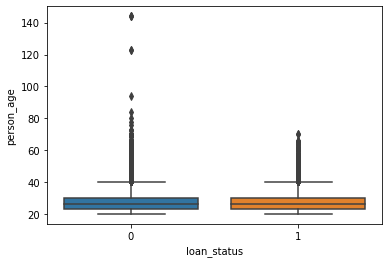

In [26]:
# Relation entre
sns.boxplot(x="loan_status", y="person_age", data=df);

NOus remarquons que l'age n'influt pas sur le remboursement du crédit

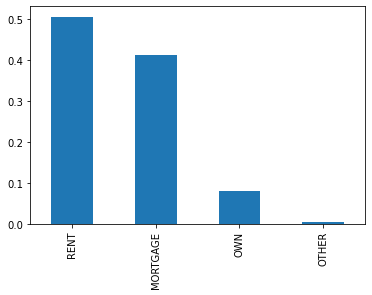

In [27]:
# Analyse de variable person_home_ownership
df["person_home_ownership"].value_counts(normalize=True).plot(
    kind = "bar"
);

Analysons les motifs de l'emprunt

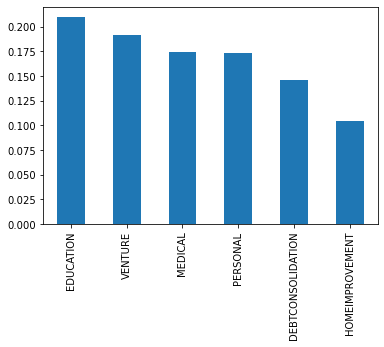

In [28]:
mask = df["loan_status"]==0
df[mask]["loan_intent"].value_counts(normalize=True).plot(
    kind = "bar"
);

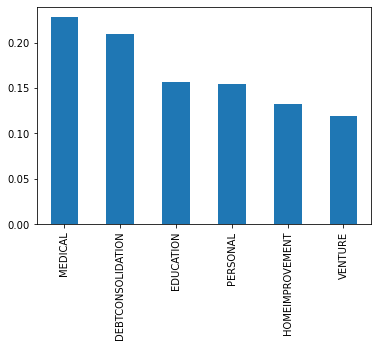

In [29]:
mask = df["loan_status"]==1
df[mask]["loan_intent"].value_counts(normalize=True).plot(
    kind = "bar"
);

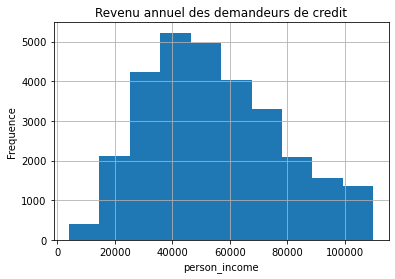

In [38]:
# resumé de la variable person_income apres nettoyage des valeur aberante
df["person_income"].hist()
plt.xlabel("person_income")
plt.ylabel("Frequence")
plt.title("Revenu annuel des demandeurs de credit");

## Split

In [6]:
target = "loan_status"
X = df.drop(columns=target)
y = df[target]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (23457, 11)
y_train shape: (23457,)
X_test shape: (5865, 11)
y_test shape: (5865,)


## Resample

### Sous-échantillonnage( UnderSampling)

In [9]:
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()
y_train_under.value_counts(normalize=True)

(10922, 11)


0    0.5
1    0.5
Name: loan_status, dtype: float64

### Sur-échantillonnage

In [11]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()
y_train_over.value_counts(normalize=True)

(35992, 11)


0    0.5
1    0.5
Name: loan_status, dtype: float64

# Build Model

## Baseline

In [12]:
print("X_train",y_train.value_counts(normalize=True))

X_train 0    0.767191
1    0.232809
Name: loan_status, dtype: float64


In [13]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline accuracy: ", round(acc_baseline, 2))

Baseline accuracy:  0.77


## Iterate

In [22]:
# fit on 'X_train', 'y_train'
model_reg = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LogisticRegression(max_iter=1000)
)
model_reg.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['person_home_ownership', 'loan_intent',
                                     'loan_grade',
                                     'cb_person_default_on_file'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [23]:
# fit on 'X_train_under', 'y_train_under'
model_under = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LogisticRegression(max_iter=1000)
)
model_under.fit(X_train_under, y_train_under)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['person_home_ownership', 'loan_intent',
                                     'loan_grade',
                                     'cb_person_default_on_file'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [24]:
# fit on 'X_train_over', 'y_train_over'
model_over = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LogisticRegression(max_iter=1000)
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['person_home_ownership', 'loan_intent',
                                     'loan_grade',
                                     'cb_person_default_on_file'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

## Evaluate

In [29]:
def model_evalution(model):
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = model.score(X_test, y_test)
    recall_train = recall_score(y_train, model.predict(X_train))
    recall_test = recall_score(y_test, model.predict(X_test))
    precision_train = precision_score(y_train, model.predict(X_train))
    precision_test = precision_score(y_test, model.predict(X_test))

    print("Training Accuracy:", round(acc_train, 2))
    print("Test Accuracy:", round(acc_test, 2))
    print()
    print("--------------------------")
    print("Training Recall:", round(recall_train, 2))
    print("Test Recall:", round(recall_test, 2))
    print()
    print("--------------------------")
    print("Training precision:", round(precision_train, 2))
    print("test precision:", round(precision_test, 2))
    ConfusionMatrixDisplay.from_estimator(model, X_test,y_test)

Training Accuracy: 0.82
Test Accuracy: 0.81

--------------------------
Training Recall: 0.43
Test Recall: 0.43

--------------------------
Training precision: 0.67
test precision: 0.63


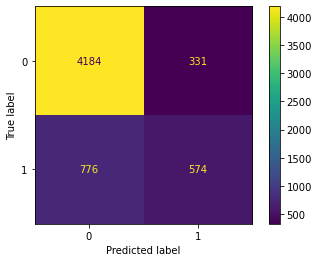

In [32]:
# with model_reg
model_evalution(model_reg)

Training Accuracy: 0.73
Test Accuracy: 0.73

--------------------------
Training Recall: 0.77
Test Recall: 0.76

--------------------------
Training precision: 0.45
test precision: 0.44


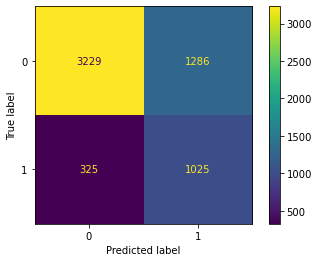

In [31]:
# with model_over
model_evalution(model_over)

Training Accuracy: 0.73
Test Accuracy: 0.72

--------------------------
Training Recall: 0.77
Test Recall: 0.76

--------------------------
Training precision: 0.45
test precision: 0.44


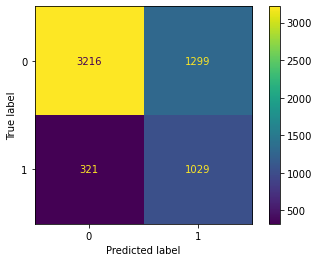

In [33]:
# with model_under
model_evalution(model_under)

## Communicate

In [35]:
y_train_pred_proba = model_reg.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.60940529 0.39059471]
 [0.49662453 0.50337547]
 [0.95999395 0.04000605]
 [0.91649566 0.08350434]
 [0.88142562 0.11857438]]


In [45]:
features = model_reg.named_steps['onehotencoder'].get_feature_names()
importances = model_reg.named_steps['logisticregression'].coef_[0]

In [49]:
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

person_age                     0.955093
person_emp_length              0.966372
loan_grade_A                   0.982449
cb_person_default_on_file_N    0.983884
loan_grade_B                   0.987910
dtype: float64

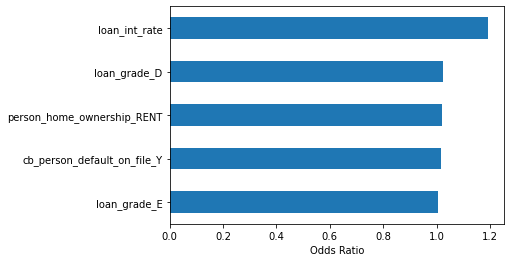

In [50]:
odds_ratios.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");

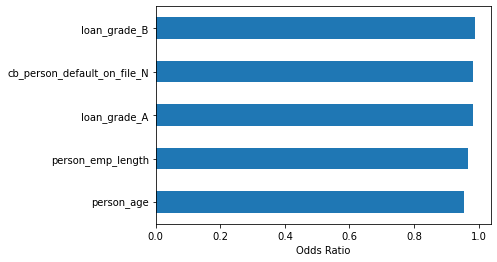

In [51]:
odds_ratios.head().plot(kind="barh")
plt.xlabel("Odds Ratio");

In [59]:
# Save your model as `"model-1.pkl"`
with open("model-1.pkl", "wb") as f:
    pickle.dump(model_over, f)

In [60]:
with open("model-1.pkl", "rb") as f:
    loaded_model = pickle.load(f)
print(loaded_model)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['person_home_ownership', 'loan_intent',
                                     'loan_grade',
                                     'cb_person_default_on_file'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression(max_iter=1000))])
